In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from zipfile import ZipFile
import pandas as pd
import torch
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

from HP import PointProcessStorage, DirichletMixtureModel, EM_clustering
from metrics import consistency
from data_utils import load_data

In [3]:
path = Path('../..', 'data', 'IPTV_Data')
ss, Ts, class2idx = load_data(path, maxlen=300)

In [4]:
N = len(ss)

In [5]:
D = 1
basis_fs = [lambda x: torch.exp(- x**2 / (10.*(k+1)) ) for k in range(D)]

In [6]:
hp = PointProcessStorage(ss, Ts, basis_fs)

In [7]:
C = len(class2idx)
K = 10

In [8]:
Sigma = (torch.eye(C, C) + torch.rand(C, C)).unsqueeze(-1).unsqueeze(-1).repeat(1,1, D, K) * 10
B = 1 + torch.rand(C, K) * 10
alpha = 1.

model = DirichletMixtureModel(K, C, D, alpha, B, Sigma)
EM = EM_clustering(hp, model, n_inner=4)


In [9]:
pi = torch.FloatTensor([1./ K for _ in range(K)])

In [10]:
print(f'Initial NLL / N: {EM.hp_nll(pi, model.mu, model.A).item() / len(ss)}')

Initial NLL / N: 66936.0


In [11]:
ntrials = 10
niter = 5

labels = torch.zeros(ntrials, len(ss))
nlls = torch.zeros(ntrials, niter)

for i in trange(ntrials):
    Sigma = (torch.eye(C, C) + torch.rand(C, C)).unsqueeze(-1).unsqueeze(-1).repeat(1,1, D, K) * 10
    B = 1 + torch.rand(C, K) * 10
    alpha = 1.

    model = DirichletMixtureModel(K, C, D, alpha, B, Sigma)
    EM.model = model
    r, nll_history = EM.learn_hp(niter=niter)
    
    labels[i] = r.argmax(-1)
    nlls[i] = torch.FloatTensor(nll_history)

100%|██████████| 10/10 [15:16<00:00, 91.60s/it]


In [12]:
assert (model.A >= 0).all()
assert (model.mu > 0).all()

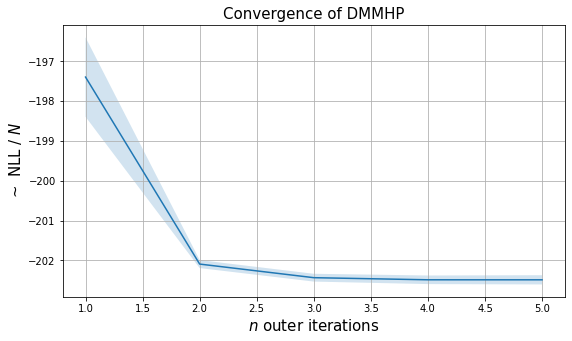

In [13]:
plt.figure(figsize=(9, 5))
plt.grid()
plt.plot(np.arange(niter)+1, nlls.mean(0).numpy() / len(ss))
plt.fill_between(np.arange(niter)+1, (nlls.mean(0).numpy() - nlls.std(0).numpy())/ len(ss), (nlls.mean(0).numpy() + nlls.std(0).numpy())/ len(ss), alpha=0.2)
plt.title('Convergence of DMMHP', fontsize=15)
plt.xlabel(r'$n$ outer iterations', fontsize=15)
plt.ylabel(r'$\sim$ NLL / $N$', fontsize=15)
plt.show()

In [14]:
print(f'Consistency of clustering: {consistency(labels).item():.4f}')

Consistency of clustering: 0.5850
